# Gaussian on a Grid Test for Hierarchical ABI with compositional score matching

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from bayesflow import diagnostics
from torch.utils.data import DataLoader, TensorDataset

from diffusion_model import HierarchicalScoreModel, SDE, weighting_function
from diffusion_sampling import euler_maruyama_sampling, adaptive_sampling, probability_ode_solving, langevin_sampling, \
    pareto_smooth_sum
from gaussian_test_simulator import Prior, Simulator, visualize_simulation_output, generate_synthetic_data
from helper_functions import generate_diffusion_time

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch_device = torch.device("cpu")

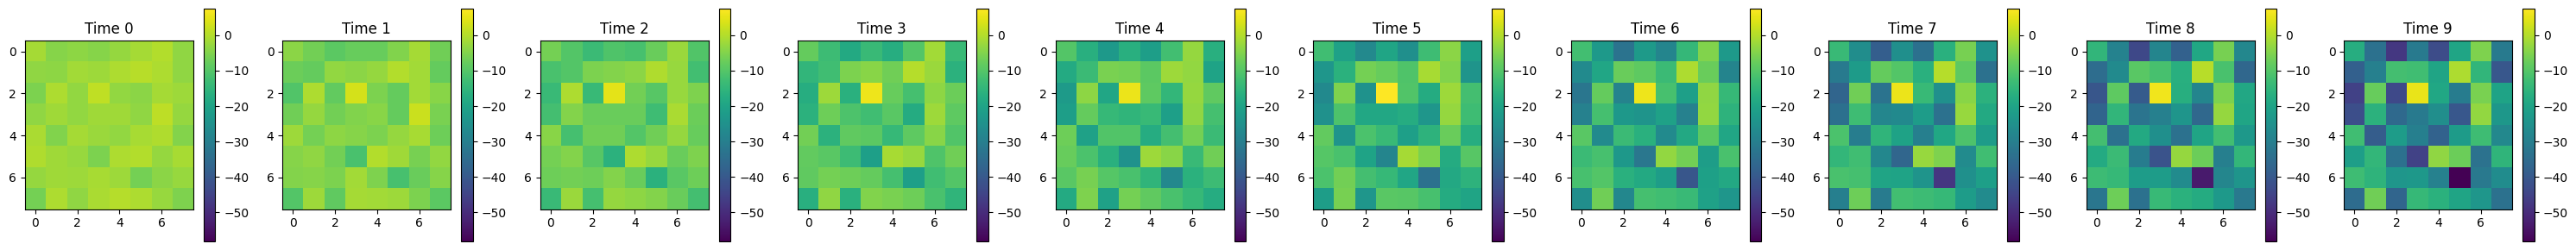

In [3]:
prior = Prior()
simulator_test = Simulator()

# test the simulator
sim_test = simulator_test(prior.sample_full(1, n_grid=8))['observable']
visualize_simulation_output(sim_test)

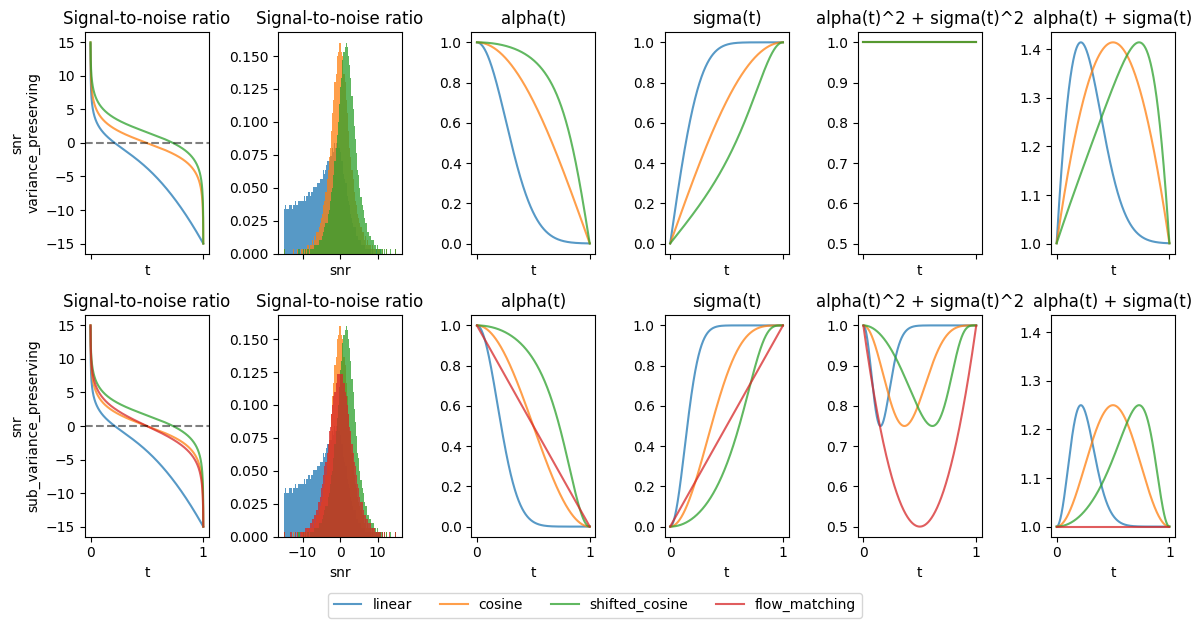

In [4]:
# plot the different snrs
t = torch.linspace(0, 1, 1000)
bins = 100

sub_vp = ['', 'sub_'][0]

fig, ax = plt.subplots(2, 6, sharex='col', sharey='col', figsize=(12, 6), tight_layout=True)
for a, sub_vp in zip(ax, ['', 'sub_']):
    snr = SDE(sub_vp+'variance_preserving', 'linear').get_snr(t)
    h1 = a[0].plot(t, snr, label='linear', alpha=0.75)
    a[1].hist(snr, bins=bins, density=True, alpha=0.75)
    alpha, sigma = SDE(sub_vp+'variance_preserving', 'linear').kernel(t)
    a[2].plot(t, alpha, label='linear', alpha=0.75)
    a[3].plot(t, sigma, label='linear', alpha=0.75)
    a[4].plot(t, alpha**2+sigma**2, label='linear', alpha=0.75)
    a[5].plot(t, alpha+sigma, label='linear', alpha=0.75)

    snr = SDE(sub_vp+'variance_preserving', 'cosine').get_snr(t)
    h2 = a[0].plot(t, snr, label='cosine', alpha=0.75)
    a[1].hist(snr, bins=bins, density=True, alpha=0.75)
    alpha, sigma = SDE(sub_vp+'variance_preserving', 'cosine').kernel(t)
    a[2].plot(t, alpha, label='cosine', alpha=0.75)
    a[3].plot(t, sigma, label='cosine', alpha=0.75)
    a[4].plot(t, alpha**2+sigma**2, label='cosine', alpha=0.75)
    a[5].plot(t, alpha+sigma, label='cosine', alpha=0.75)

    snr = SDE(sub_vp+'variance_preserving', 'cosine', s_shift_cosine=0.8).get_snr(t)
    h3 = a[0].plot(t, snr, label='shifted_cosine', alpha=0.75)
    a[1].hist(snr, bins=bins, density=True, alpha=0.75)
    alpha, sigma = SDE(sub_vp+'variance_preserving', 'cosine', s_shift_cosine=0.8).kernel(t)
    a[2].plot(t, alpha, label='shifted_cosine', alpha=0.75)
    a[3].plot(t, sigma, label='shifted_cosine', alpha=0.75)
    a[4].plot(t, alpha**2+sigma**2, label='shifted_cosine', alpha=0.75)
    a[5].plot(t, alpha+sigma, label='shifted_cosine', alpha=0.75)

    if sub_vp == 'sub_':
        snr = SDE(sub_vp+'variance_preserving', 'flow_matching').get_snr(t)
        h4 = a[0].plot(t, snr, label='flow_matching', alpha=0.75)
        a[1].hist(snr, bins=bins, density=True, alpha=0.75)
        alpha, sigma = SDE(sub_vp+'variance_preserving', 'flow_matching').kernel(t)
        a[2].plot(t, alpha, label='flow_matching', alpha=0.75)
        a[3].plot(t, sigma, label='flow_matching', alpha=0.75)
        a[4].plot(t, alpha**2+sigma**2, label='flow_matching', alpha=0.75)
        a[5].plot(t, alpha+sigma, label='flow_matching', alpha=0.75)

    # dotted line at 0
    a[0].axhline(0, color='black', linestyle='--', alpha=0.5)

    for axis in a:
        axis.set_xlabel('t')
    a[1].set_xlabel('snr')
    a[0].set_ylabel(f'snr\n{sub_vp}variance_preserving')
    a[0].set_title(f'Signal-to-noise ratio')
    a[1].set_title(f'Signal-to-noise ratio')
    a[2].set_title(f'alpha(t)')
    a[3].set_title(f'sigma(t)')
    a[4].set_title(f'alpha(t)^2 + sigma(t)^2')
    a[5].set_title(f'alpha(t) + sigma(t)')
fig.legend(handles=h1+h2+h3+h4, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('plots/noise schedules.png', bbox_inches='tight')
plt.show()

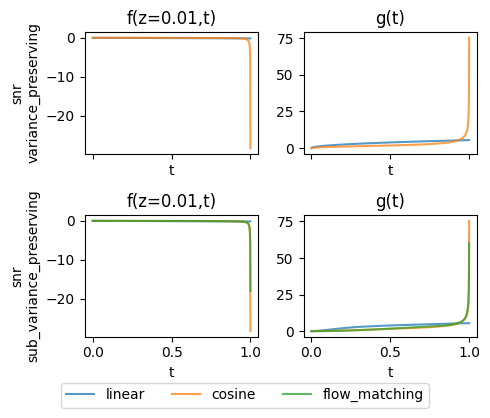

In [5]:
t = torch.linspace(0, 1, 1000)
x_0 = torch.tensor([0.01])

fig, ax = plt.subplots(2, 2, sharex='col', sharey='col', figsize=(5, 4), tight_layout=True)
for a, sub_vp in zip(ax, ['', 'sub_']):
    f, g = SDE(sub_vp+'variance_preserving', 'linear').get_f_g(t, x=x_0)
    h1 = a[0].plot(t, f, label='linear', alpha=0.75)
    a[1].plot(t, g, label='linear', alpha=0.75)

    f, g = SDE(sub_vp+'variance_preserving', 'cosine').get_f_g(t, x=x_0)
    h2 = a[0].plot(t, f, label='cosine', alpha=0.75)
    a[1].plot(t, g, label='cosine', alpha=0.75)

    #f, g = SDE(sub_vp+'variance_preserving', 'cosine', s_shift_cosine=0.8).get_f_g(t, x=x_0)
    #h3 = a[0].plot(t, f, label='shifted_cosine', alpha=0.75)
    #a[1].plot(t, g, label='shifted_cosine', alpha=0.75)

    if sub_vp == 'sub_':
        f, g = SDE(sub_vp+'variance_preserving', 'flow_matching').get_f_g(t, x=x_0)
        h4 = a[0].plot(t, f, label='flow_matching', alpha=0.75)
        a[1].plot(t, g, label='flow_matching', alpha=0.75)

    for axis in a:
        axis.set_xlabel('t')
    a[0].set_ylabel(f'snr\n{sub_vp}variance_preserving')
    a[0].set_title(f'f(z={round(x_0.item(), 2)},t)')
    a[1].set_title(f'g(t)')
fig.legend(handles=h1+h2+h4, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.show()

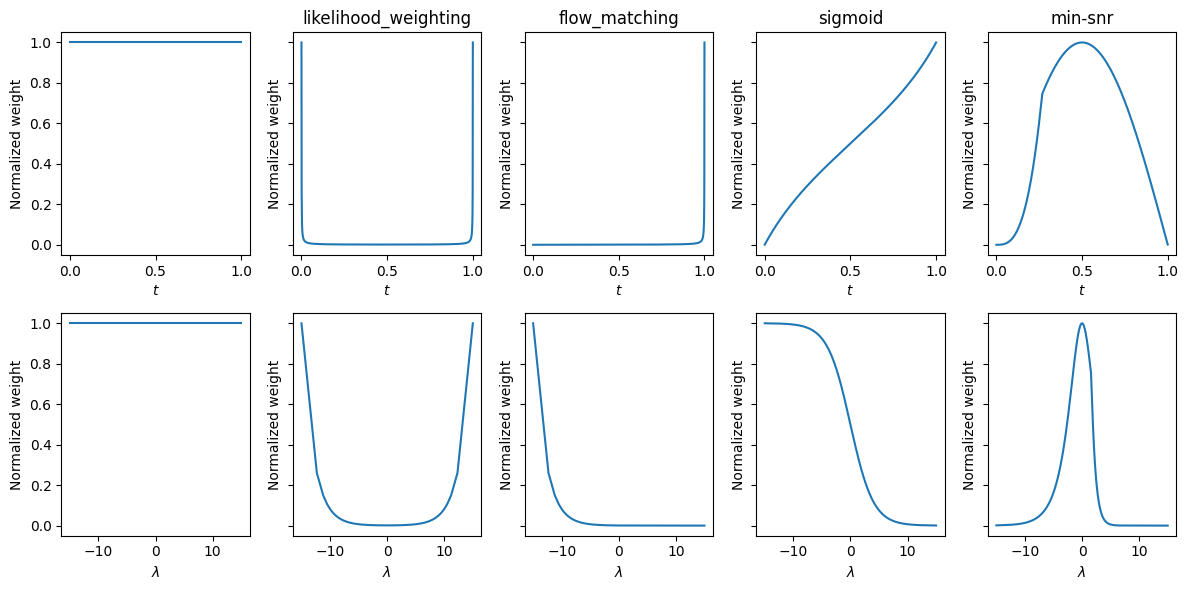

In [6]:
# plot the kernel
t = generate_diffusion_time(1000)
sde_test = SDE('variance_preserving', 'cosine')
snr = sde_test.get_snr(t)

fig, ax = plt.subplots(2, 5, sharex='row', sharey='row', figsize=(12, 6), tight_layout=True)
for a, wt in zip(ax.T, [None, 'likelihood_weighting', 'flow_matching', 'sigmoid', 'min-snr']):
    w = weighting_function(t, sde_test, weighting_type=wt)
    a[0].plot(t, w / max(w))
    a[0].set_xlabel(r'$t$')
    a[0].set_ylabel('Normalized weight')
    a[0].set_title(wt)

    a[1].plot(snr, w / max(w))
    a[1].set_xlabel(r'$\lambda$')
    a[1].set_ylabel('Normalized weight')
    a[0].set_title(wt)
#plt.savefig(f'plots/weighting_functions_{sde_test.noise_schedule}.png', bbox_inches='tight')
plt.show()

In [7]:
def compute_score_loss(theta_global_batch, theta_local_batch, x_batch, model, epsilon_global_batch=None, epsilon_local_batch=None):
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=theta_global_batch.shape[0], return_batch=True, device=theta_global_batch.device)

    # sample from the Gaussian kernel, just learn the noise
    if epsilon_global_batch is None:
        epsilon_global_batch = torch.randn_like(theta_global_batch, dtype=theta_global_batch.dtype, device=theta_global_batch.device)
    if epsilon_local_batch is None:
        epsilon_local_batch = torch.randn_like(theta_local_batch, dtype=theta_local_batch.dtype, device=theta_local_batch.device)

    # perturb the theta batch
    alpha, sigma = model.sde.kernel(t=diffusion_time)
    z_global = alpha * theta_global_batch + sigma * epsilon_global_batch
    if score_model.global_number_of_obs > 1:
        # global params are not factorized to the same level as local params
        z_local = alpha.unsqueeze(1) * theta_local_batch + sigma.unsqueeze(1) * epsilon_local_batch
    else:
        z_local = alpha * theta_local_batch + sigma * epsilon_local_batch
    # predict from perturbed theta
    pred_global, pred_local = model(theta_global=z_global, theta_local=z_local,
                                    time=diffusion_time, x=x_batch, pred_score=False)

    effective_weight = weighting_function(diffusion_time, sde=model.sde, weighting_type=model.weighting_type,
                                          prediction_type=model.prediction_type)
    # calculate the loss (sum over the last dimension, mean over the batch)
    loss_global = torch.mean(effective_weight * torch.sum(torch.square(pred_global - epsilon_global_batch), dim=-1))
    loss_local = torch.mean(effective_weight * torch.sum(torch.square(pred_local - epsilon_local_batch), dim=-1))
    return loss_global + loss_local


# Training loop for Score Model
def train_score_model(model, dataloader, dataloader_valid=None, epochs=100, lr=1e-4, rectified_flow=False, device=None):
    print(f"Training {model.prediction_type}-model for {epochs} epochs with learning rate {lr} and {model.sde.kernel_type},"
          f" {model.sde.noise_schedule} schedule and {model.weighting_type} weighting.")
    if model.sde.noise_schedule == 'flow_matching':
        rectified_flow = True
    if rectified_flow:
        print(f'Using rectified flow.')
    print(f"Model has {model.n_params_global} global parameters and {model.n_params_local} local parameters and is uses compositional conditioning with {model.global_number_of_obs} factors.")
    score_model.to(torch_device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Add Cosine Annealing Scheduler
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Training loop
    loss_history = np.zeros((epochs, 2))
    for epoch in range(epochs):
        model.train()
        total_loss = []
        # for each sample in the batch, calculate the loss for a random diffusion time
        for theta_global_batch, epsilon_global_batch, theta_local_batch, epsilon_local_batch, x_batch in dataloader:
            # initialize the gradients
            optimizer.zero_grad()
            theta_global_batch = theta_global_batch.to(device)
            theta_local_batch = theta_local_batch.to(device)
            x_batch = x_batch.to(device)
            if rectified_flow:
                epsilon_batch = torch.concat([epsilon_global_batch, epsilon_local_batch], dim=-1).to(device)
                # calculate the loss
                loss = compute_score_loss(theta_global_batch=theta_global_batch, theta_local_batch=theta_local_batch,
                                          epsilon_global_batch=epsilon_global_batch, epsilon_local_batch=epsilon_local_batch,
                                          x_batch=x_batch, model=model)
            else:
                # calculate the loss
                loss = compute_score_loss(theta_global_batch=theta_global_batch, theta_local_batch=theta_local_batch,
                                          x_batch=x_batch, model=model)
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()
            total_loss.append(loss.item())
        #scheduler.step()

        # validate the model
        model.eval()
        valid_loss = []
        if dataloader_valid is not None:
            with torch.no_grad():
                for theta_global_batch, epsilon_global_batch, theta_local_batch, epsilon_local_batch, x_batch in dataloader_valid:
                    theta_global_batch = theta_global_batch.to(device)
                    theta_local_batch = theta_local_batch.to(device)
                    x_batch = x_batch.to(device)
                    if rectified_flow:
                        epsilon_batch = torch.concat([epsilon_global_batch, epsilon_local_batch], dim=-1).to(device)
                        # calculate the loss
                        loss = compute_score_loss(theta_global_batch=theta_global_batch, theta_local_batch=theta_local_batch,
                                                  epsilon_global_batch=epsilon_global_batch, epsilon_local_batch=epsilon_local_batch,
                                                  x_batch=x_batch, model=model)
                    else:
                        # calculate the loss
                        loss = compute_score_loss(theta_global_batch=theta_global_batch, theta_local_batch=theta_local_batch,
                                                  epsilon_global_batch=epsilon_global_batch, epsilon_local_batch=epsilon_local_batch,
                                                  x_batch=x_batch, model=model)
                    valid_loss.append(loss.item())

        loss_history[epoch] = [np.mean(total_loss), np.mean(valid_loss)]
        print_str = f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(total_loss):.4f}, "\
                    f"Valid Loss: {np.mean(valid_loss):.4f}"
        print(print_str, end='\r')
        # Update the checkpoint after each epoch of training.
        #torch.save(model.state_dict(), 'ckpt.pth')
    return loss_history

In [8]:
# Hyperparameters
n_data = 25000
batch_size = 128
factorize_global = 4

# Create model and dataset
thetas_global, thetas_local, xs = generate_synthetic_data(
    prior,
    grid_size=int(np.sqrt(factorize_global)) if factorize_global > 1 else None,
    full='batch' if factorize_global > 1 else None,
    n_data=n_data, normalize=True
)
epsilon_global = torch.randn_like(thetas_global, dtype=torch.float32)
epsilon_local = torch.randn_like(thetas_local, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(thetas_global, epsilon_global, thetas_local, epsilon_local, xs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# create validation data
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(
    prior,
    grid_size=int(np.sqrt(factorize_global)) if factorize_global > 1 else None,
    full='batch' if factorize_global > 1 else None,
    n_data=batch_size*2, normalize=True
)
epsilon_global = torch.randn_like(valid_prior_global, dtype=torch.float32)
epsilon_local = torch.randn_like(valid_prior_local, dtype=torch.float32)

dataset_valid = TensorDataset(valid_prior_global, epsilon_global, valid_prior_local, epsilon_local, valid_data)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size)

Moving prior to device cpu


In [9]:
# Define model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][0]
)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x=1,
    hidden_dim=64,
    n_blocks=3,
    global_number_of_obs=factorize_global,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=True,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior
)

print(score_model.name)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

hierarchical_score_model_v_variance_preserving_linear_likelihood_weighting_factorized4


In [10]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=500, lr=1e-4, device=torch_device)
score_model.eval();

Training v-model for 500 epochs with learning rate 0.0001 and variance_preserving, linear schedule and likelihood_weighting weighting.
Model has 2 global parameters and 1 local parameters and is uses compositional conditioning with 4 factors.


In [12]:
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

In [13]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

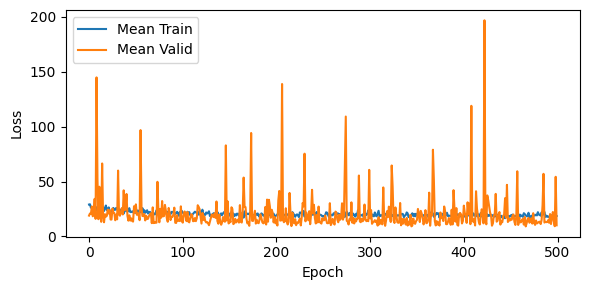

In [14]:
# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

In [15]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w = {}
loss_list_error = {}

with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        for theta_global_batch, _, theta_local_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            theta_local_batch = theta_local_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)
            epsilon_local = torch.randn_like(theta_local_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            alpha, sigma = score_model.sde.kernel(t=t_tensor)
            snr = torch.log(torch.square(alpha)) - torch.log(torch.square(sigma))
            z_global = alpha * theta_global_batch + sigma * epsilon_global
            if score_model.global_number_of_obs > 1:
                # global params are not factorized to the same level as local params
                alpha_local = alpha.unsqueeze(1)
                sigma_local = sigma.unsqueeze(1)
            else:
                alpha_local = alpha
                sigma_local = sigma
            z_local = alpha_local * theta_local_batch + sigma_local * epsilon_local

            # predict from perturbed theta
            pred_epsilon_global, pred_epsilon_local = score_model(theta_global=z_global, theta_local=z_local,
                                       time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global, pred_score_local = score_model(theta_global=z_global, theta_local=z_local,
                                     time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)
            if score_model.global_number_of_obs == 1:
                true_score_local = score_model.sde.grad_log_kernel(x=z_local,
                                                                   x0=theta_local_batch,
                                                                   t=t_tensor)
            else:
                true_score_local = []
                for i in range(score_model.global_number_of_obs):
                    score_local = score_model.sde.grad_log_kernel(x=z_local[:, i],
                                                                   x0=theta_local_batch[:, i],
                                                                   t=t_tensor)
                    true_score_local.append(score_local.unsqueeze(1))
                true_score_local = torch.concatenate(true_score_local, dim=1)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
                target_local = -epsilon_local / sigma_local
                pred_target_local = -pred_epsilon_local / sigma_local
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
                target_local = epsilon_local
                pred_target_local = pred_epsilon_local
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
                target_local = alpha_local*epsilon_local - sigma_local * theta_local_batch
                pred_target_local = alpha_local*pred_epsilon_local - sigma_local * theta_local_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
                target_local = theta_local_batch
                pred_target_local = (z_local - pred_epsilon_local * sigma_local) / alpha_local
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_target_local - target_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_target[t.item()] = loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_score_local - true_score_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_score[t.item()] = loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_local = torch.mean(w * torch.sum(torch.square(pred_epsilon_local - epsilon_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_error_w[t.item()] = loss.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_epsilon_local - epsilon_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_error[t.item()] = loss.item()

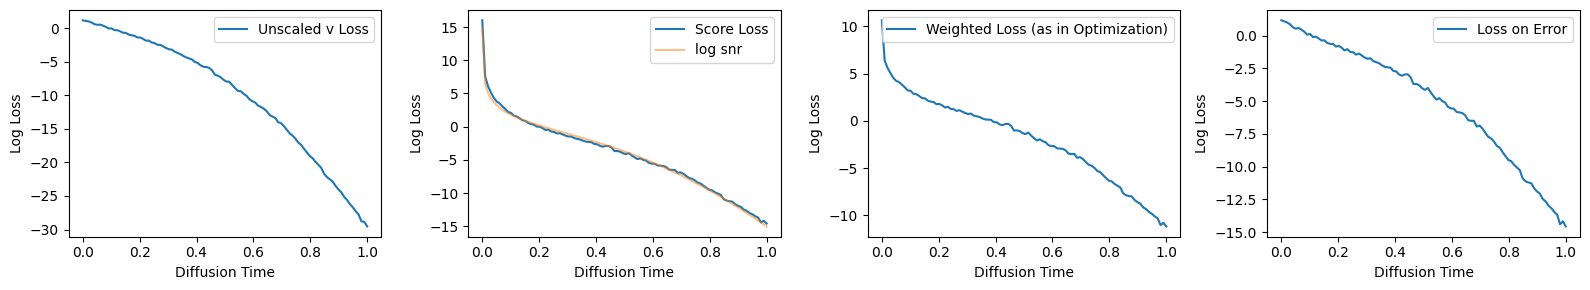

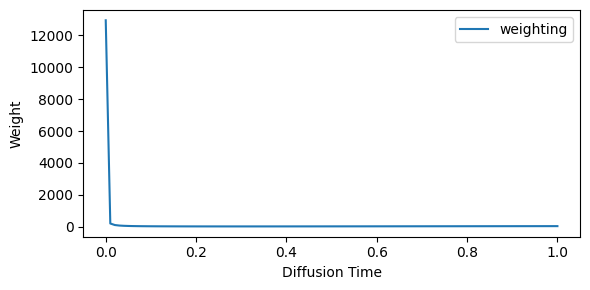

In [16]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w = pd.DataFrame(loss_list_error_w.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time)
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time, snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w['Time'], np.log(df_error_w['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [17]:
n_grid = 8
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior, n_data=10, grid_size=n_grid,
                                                                            normalize=False, random_seed=0)
n_post_samples = 20

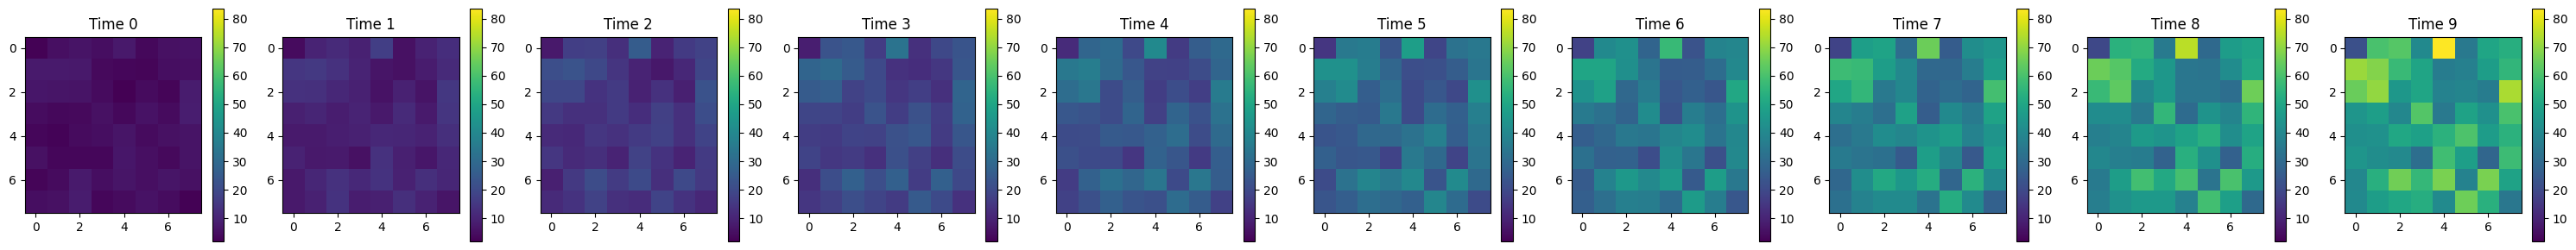

In [18]:
visualize_simulation_output(valid_data)

In [19]:
posterior_global_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                             #n_scores_update=10,
                                                            diffusion_steps=100, langevin_steps=5, step_size_factor=0.05,
                                           device=torch_device)
                                        for vd in valid_data])

100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


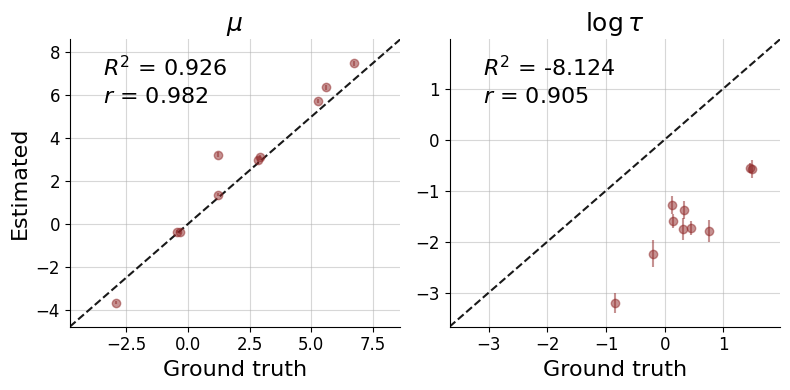

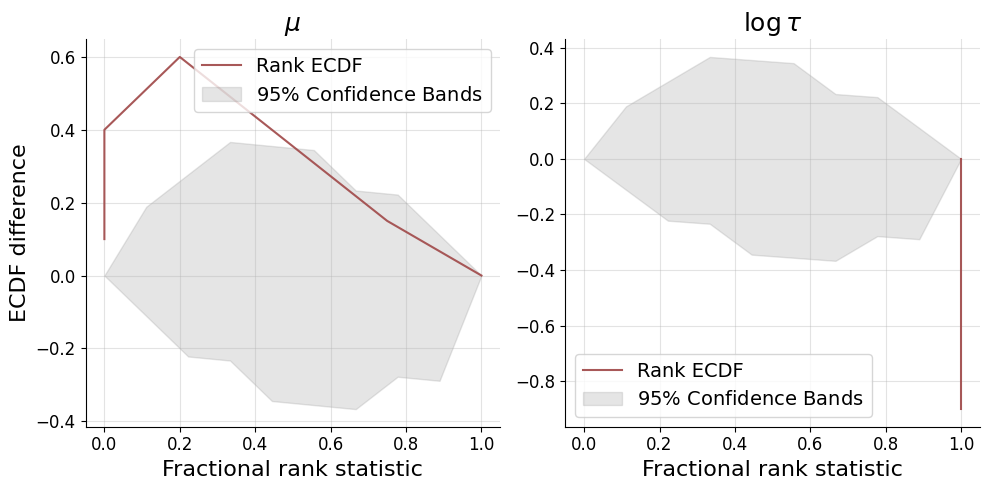

In [20]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler.png')

In [21]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   #n_scores_update=10,
                                                                   diffusion_steps=1000, device=torch_device)
                                        for vd in valid_data])

100%|██████████| 1000/1000 [00:06<00:00, 147.56it/s]


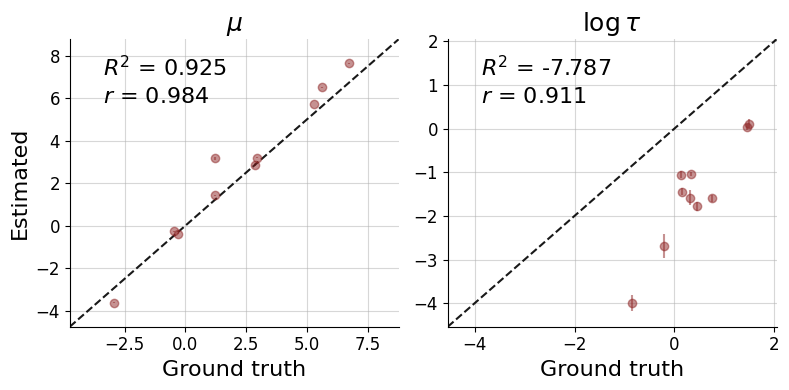

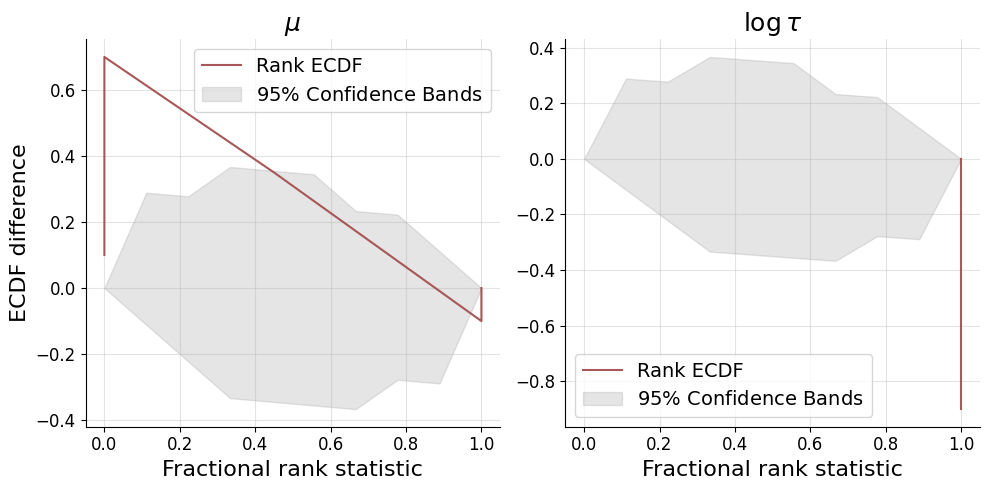

In [22]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler.png')

In [24]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   n_scores_update=10,
                                                                   diffusion_steps=200, device=torch_device)
                                        for vd in valid_data])

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: shape '[40, 4, 10, 1]' is invalid for input of size 2000

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler.png')

In [25]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   #n_scores_update=10,
                                                                   pareto_smooth_fraction=0.3,
                                                                   diffusion_steps=200, device=torch_device)
                                        for vd in valid_data])

  2%|▎         | 5/200 [00:02<01:19,  2.45it/s]


KeyboardInterrupt: 

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_pareto_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_pareto_sampler.png')

In [26]:
posterior_global_samples_valid = np.array([adaptive_sampling(score_model, vd, n_post_samples,
                                                             #n_scores_update=10,
                                                             e_rel=1.5, max_steps=2000, device=torch_device)
                                        for vd in valid_data])

 10%|█         | 206/2000 [00:02<00:23, 76.82it/s]


Finished after 207 steps (414 score evals) at time 0.0.
Mean step size: 0.00775193702429533, min: 0.00017026370915118605, max: 0.03134866803884506


 11%|█▏        | 229/2000 [00:02<00:21, 80.92it/s]


Finished after 230 steps (460 score evals) at time 0.0.
Mean step size: 0.007751937955617905, min: 0.0009360840194858611, max: 0.0224654208868742


 10%|█         | 205/2000 [00:02<00:21, 83.19it/s]


Finished after 206 steps (412 score evals) at time 0.0.
Mean step size: 0.008130080997943878, min: 0.0017261393368244171, max: 0.018369564786553383


 10%|█         | 207/2000 [00:02<00:21, 83.22it/s]


Finished after 208 steps (416 score evals) at time 0.0.
Mean step size: 0.0080645140260458, min: 0.0001473699085181579, max: 0.030583685263991356


 10%|█         | 207/2000 [00:02<00:20, 89.52it/s]


Finished after 208 steps (416 score evals) at time 0.0.
Mean step size: 0.007999999448657036, min: 0.00017736143490765244, max: 0.030881959944963455


 11%|█         | 220/2000 [00:02<00:20, 85.71it/s]


Finished after 221 steps (442 score evals) at time 0.0.
Mean step size: 0.007874015718698502, min: 0.000948794127907604, max: 0.025411957874894142


 11%|█         | 224/2000 [00:02<00:20, 87.11it/s]


Finished after 225 steps (450 score evals) at time 0.0.
Mean step size: 0.007874015718698502, min: 0.0012196218594908714, max: 0.022802460938692093


 11%|█         | 220/2000 [00:02<00:19, 89.12it/s]


Finished after 221 steps (442 score evals) at time 0.0.
Mean step size: 0.007518795318901539, min: 0.0005340506904758513, max: 0.01871396042406559


  9%|▉         | 184/2000 [00:02<00:21, 86.36it/s]


Finished after 185 steps (370 score evals) at time 0.0.
Mean step size: 0.008695653639733791, min: 0.0016482084756717086, max: 0.021612636744976044


 12%|█▏        | 246/2000 [00:02<00:21, 82.81it/s]

Finished after 247 steps (494 score evals) at time 0.0.
Mean step size: 0.006993005983531475, min: 0.0007268834742717445, max: 0.014718129299581051


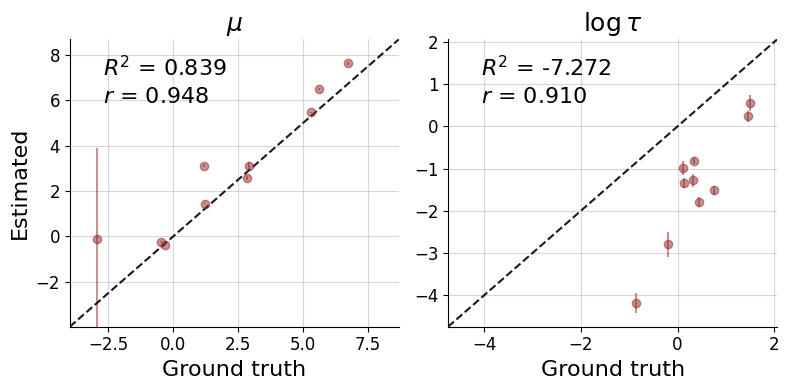

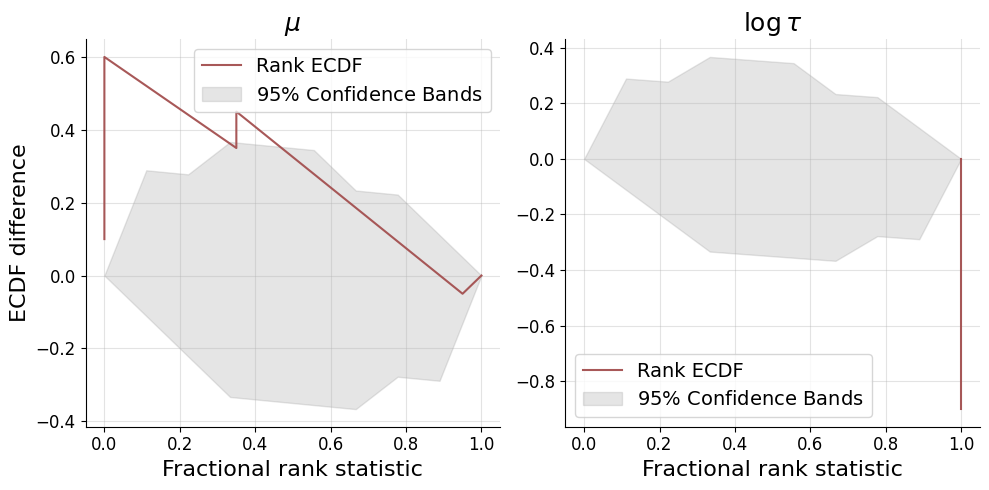

In [27]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [28]:
posterior_global_samples_valid = np.zeros((len(valid_data), n_post_samples, 2))
for i, vd in enumerate(valid_data):
    # solve for every sample individually, much slower, and still most of the samples were similar
    #for j in range(n_post_samples):
    #    posterior_global_samples_valid[i, j] = probability_ode_solving(score_model, vd, n_post_samples=1,
    #                                                                    device=torch_device)
    # solve for all samples at once
    posterior_global_samples_valid[i] = probability_ode_solving(score_model, vd, n_post_samples=n_post_samples,
                                                                #n_scores_update=10,
                                                                device=torch_device)

ODE solved: True with #score evals: 650
ODE solved: True with #score evals: 626
ODE solved: True with #score evals: 674
ODE solved: True with #score evals: 632
ODE solved: True with #score evals: 632
ODE solved: True with #score evals: 710
ODE solved: True with #score evals: 710
ODE solved: True with #score evals: 1022
ODE solved: True with #score evals: 1064
ODE solved: True with #score evals: 752


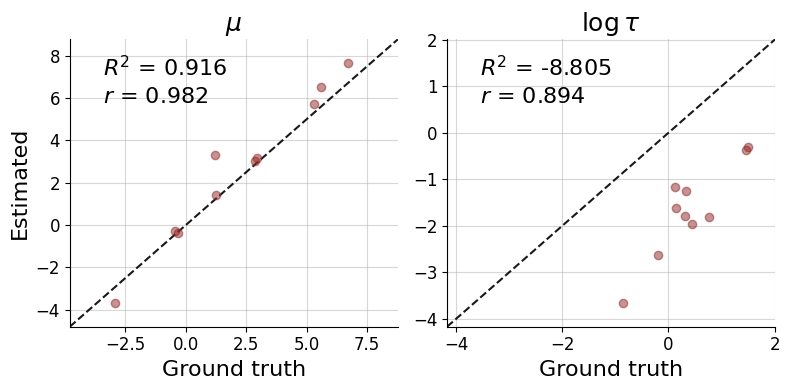

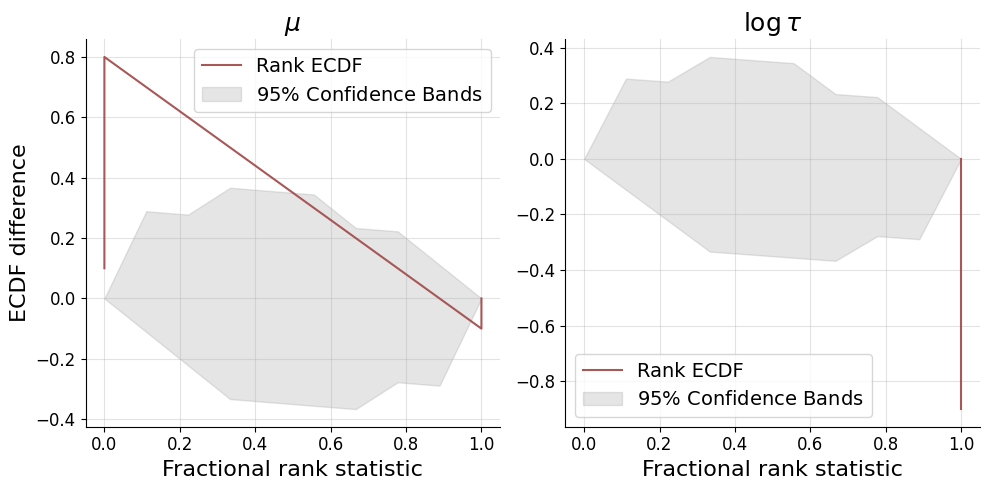

In [29]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/recovery_global_ode.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode.png')

In [31]:
#conditions_global = np.median(posterior_global_samples_valid, axis=0)
posterior_local_samples_valid = np.array([euler_maruyama_sampling(score_model, vd,
                                                                  n_post_samples=n_post_samples, conditions=c,
                                                                  diffusion_steps=50, device=torch_device)
                                        for vd, c in zip(valid_data, posterior_global_samples_valid)])

  0%|          | 0/50 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [ ]:
diagnostics.plot_recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          param_names=['$\\theta_{'+str(i)+'}$' for i in range(n_grid**2)]);

In [32]:
#conditions_global = np.median(posterior_global_samples_valid, axis=1)
posterior_local_samples_valid = np.array([probability_ode_solving(score_model, vd, n_post_samples=n_post_samples,
                                                                  conditions=c, device=torch_device)
                                        for vd, c in zip(valid_data, posterior_global_samples_valid)])

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [ ]:
diagnostics.plot_recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          param_names=['$\\theta_{'+str(i)+'}$' for i in range(n_grid**2)]);

In [ ]:
valid_id = 0
print('Data')
visualize_simulation_output(valid_data[valid_id])
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log tau:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log tau:', valid_prior_global[valid_id][1].item())

In [ ]:
med = np.median(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
std = np.std(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
error = (med-valid_prior_local[valid_id].numpy())**2
visualize_simulation_output(np.stack((med, valid_prior_local[valid_id], )),
                            title_prefix=['Posterior Median', 'True'])

visualize_simulation_output(np.stack((std, error)), title_prefix=['Uncertainty', 'Error'], same_scale=False)

# Visualize the Score

In [33]:
n_grid = 8
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior, n_data=10, grid_size=n_grid,
                                                                            normalize=False, random_seed=0)

valid_id = 5 #0

diffusion_time = generate_diffusion_time(size=10, device=torch_device)
x_valid = valid_data[valid_id].to(torch_device)
x_valid_norm = score_model.prior.normalize_data(x_valid)
theta_global = score_model.prior.normalize_theta(valid_prior_global[valid_id], global_params=True).cpu().numpy()  # we normalize as the score is normalized space
print(valid_id, 'theta global', theta_global)

5 theta global [-0.94426537  0.33058316]


In [ ]:
test_sample = adaptive_sampling(score_model, x_valid, conditions=None, n_post_samples=1, #e_abs=0.00078,
                                e_rel=1.5, max_steps=1000, t_end=diffusion_time[0], random_seed=0, device=torch_device)
test_sample = score_model.prior.normalize_theta(torch.tensor(test_sample), global_params=True).cpu().numpy()
print(test_sample)

In [ ]:
# posterior_sample_path = np.array([adaptive_sampling(score_model, x_valid, conditions=None, n_post_samples=1,
#                                                                   e_rel=1.5, max_steps=1000, t_end=t, random_seed=0, device=torch_device)
#                                   for t in diffusion_time[:-1]])
posterior_sample_path = np.array([euler_maruyama_sampling(score_model, x_valid, diffusion_steps=1000,
                                                           conditions=None, n_post_samples=1, t_end=t, random_seed=0, device=torch_device)
                                  for t in diffusion_time[:-1]])
# we normalize as the score is normalized space
posterior_sample_path = score_model.prior.normalize_theta(torch.tensor(posterior_sample_path), global_params=True).cpu().numpy()

posterior_sample_path2 = np.array([euler_maruyama_sampling(score_model, x_valid, diffusion_steps=200,
                                                           pareto_smooth_fraction=0.1,
                                                           conditions=None, n_post_samples=1, t_end=t, random_seed=0, device=torch_device)
                                  for t in diffusion_time[:-1]])
# we normalize as the score is normalized space
posterior_sample_path2 = prior.normalize_theta(torch.tensor(posterior_sample_path2), global_params=True).cpu().numpy()

posterior_sample_path3 = np.array([probability_ode_solving(score_model, x_valid,
                                                           conditions=None, n_post_samples=1, t_end=t, random_seed=0, device=torch_device)
                                  for t in diffusion_time[:-1]])
# we normalize as the score is normalized space
posterior_sample_path3 = score_model.prior.normalize_theta(torch.tensor(posterior_sample_path3), global_params=True).cpu().numpy()

print('theta global', theta_global, posterior_sample_path[0].flatten())

In [ ]:
# Define grid boundaries and resolution for your 2D space.
x_min, x_max, y_min, y_max = -1.5, 1.5, -1.5, 1.5
grid_res = 10  # Number of points per dimension

# Create a meshgrid of points
x_vals = np.linspace(x_min, x_max, grid_res)
y_vals = np.linspace(y_min, y_max, grid_res)
xx, yy = np.meshgrid(x_vals, y_vals)
# Stack into (N,2) where N = grid_res*grid_res
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Convert grid to a torch tensor and move to device
grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=torch_device)
x_valid_norm_e = x_valid_norm.reshape(10, -1).to(torch_device)
x_valid_norm_ext = x_valid_norm_e.unsqueeze(0).repeat(grid_tensor.shape[0], 1, 1)

# Dictionary to hold score outputs for each time
scores = {}
scores_smoothed = {}
drifts = {}
drifts_smoothed = {}

with torch.no_grad():
    # Evaluate the score model for each time value
    for t in diffusion_time:
        # Create a tensor of time values for each grid point
        t_tensor = torch.full((grid_tensor.shape[0], 1), t.item(), dtype=torch.float32, device=torch_device)
        epsilon = torch.randn_like(grid_tensor, dtype=torch.float32, device=torch_device)

        # perturb theta
        alpha, sigma = score_model.sde.kernel(t=t_tensor)
        z = grid_tensor #alpha * grid_tensor + sigma * epsilon

        # Evaluate the score model
        score_indv = torch.zeros((x_valid_norm_ext.shape[2], grid_tensor.shape[0], 2))

        prior_scores = (1 - t) * score_model.prior.score_global_batch(z)
        prior_scores_indv = prior_scores.unsqueeze(0)
        for i in range(x_valid_norm_ext.shape[2]):
            score_indv[i] = score_model.forward_global(theta_global=z, time=t_tensor, x=x_valid_norm_ext[:, :, i].unsqueeze(-1),
                                                       pred_score=True, clip_x=False)
        score_indv = score_indv - prior_scores_indv

        score = score_indv.sum(axis=0)
        score = score + prior_scores
        scores[t.item()] = score.cpu().numpy()

        score_pareto = torch.zeros_like(score)
        for i in range(score_indv.shape[1]):
            score_pareto[i] = pareto_smooth_sum(score_indv[:, i].unsqueeze(0),
                                                   tail_fraction=0.3)[0]  # expects dim to be the batch

        score_pareto = score_pareto + prior_scores
        scores_smoothed[t.item()] = score_pareto.cpu().numpy()

        f, g = score_model.sde.get_f_g(x=z, t=t_tensor)
        drift = f - 0.5 * torch.square(g) * scores[t.item()]
        drifts[t.item()] = drift.cpu().numpy()

        drift_pareto = f - 0.5 * torch.square(g) * scores_smoothed[t.item()]
        drifts_smoothed[t.item()] = drift_pareto.cpu().numpy()

In [ ]:
# Plot the vector field (score) for each time step using subplots
nrows = 2
fig, axes = plt.subplots(nrows, len(diffusion_time) // nrows, sharex=True, sharey=True,
                         figsize=(15, 3*nrows), tight_layout=True)
axes = axes.flatten()

for i, (t_val, score_val) in enumerate(sorted(scores.items(), reverse=True)):
    # Reshape score components back to (grid_res, grid_res) for quiver plotting
    U = score_val[:, 0].reshape(grid_res, grid_res)
    V = score_val[:, 1].reshape(grid_res, grid_res)  # negative since we are plotting the reverse score

    ax = axes[i]

    h0, = ax.plot(0, 0, 'o', color='black', label='Latent Prior')
    h1, = ax.plot(theta_global[0], theta_global[1], 'ro', label='True Parameter')

    if i != 0:
        j = i
        h2, = ax.plot(posterior_sample_path[:-j, 0, 0], posterior_sample_path[:-j, 0, 1], 'o-', label='Posterior Path Sampling', alpha=0.5)
        #h3, = ax.plot(posterior_sample_path2[j:, 0, 0], posterior_sample_path2[j:, 0, 1], 'o-', label='Posterior Path Euler', alpha=0.5)
        h4, = ax.plot(posterior_sample_path3[:-j, 0, 0], posterior_sample_path3[:-j, 0, 1], 'o-', label='Posterior Path ODE', alpha=0.5)
    h5 = ax.quiver(xx, yy, U, V, color='blue', angles='xy', scale_units='xy', scale=5*n_grid*n_grid, alpha=.75, label='Score')
    ax.set_title(f"Diffusion t = {t_val:.3f}")
    ax.set_xlim(x_min-0.5, x_max+0.5)
    ax.set_ylim(y_min-0.5, y_max+0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    #ax.legend()
    #print(posterior_sample_path[i, 0, 0], posterior_sample_path[i, 0, 1])
fig.legend(handles=[h5, h0, h1, h2, h4], loc='lower center', ncols=5, bbox_to_anchor=(0.5, -0.05))
plt.savefig(f'plots/{score_model.name}/score.png', bbox_inches='tight')
plt.show()
print('theta global', theta_global, posterior_sample_path[0].flatten())

In [ ]:
# Plot the vector field (score) for each time step using subplots
nrows = 2
fig, axes = plt.subplots(nrows, len(diffusion_time) // nrows, sharex=True, sharey=True,
                         figsize=(15, 3*nrows), tight_layout=True)
axes = axes.flatten()

for i, (t_val, score_val) in enumerate(sorted(drifts.items(), reverse=True)):
    # Reshape score components back to (grid_res, grid_res) for quiver plotting
    U = score_val[:, 0].reshape(grid_res, grid_res)
    V = score_val[:, 1].reshape(grid_res, grid_res)

    ax = axes[i]
    h0, = ax.plot(0, 0, 'o', color='black', label='Latent Prior')
    h1, = ax.plot(theta_global[0], theta_global[1], 'ro', label='True Parameter')

    j = len(diffusion_time)-i-1
    h2, = ax.plot(posterior_sample_path[j:, 0, 0], posterior_sample_path[j:, 0, 1], 'o-', label='Posterior Path Sampling', alpha=0.5)
    #h3, = ax.plot(posterior_sample_path2[j:, 0, 0], posterior_sample_path2[j:, 0, 1], 'o-', label='Posterior Path Euler', alpha=0.5)
    h4, = ax.plot(posterior_sample_path3[j:, 0, 0], posterior_sample_path3[j:, 0, 1], 'o-', label='Posterior Path ODE', alpha=0.5)
    h5 = ax.quiver(xx, yy, U, V, color='blue', angles='xy', scale_units='xy', scale=5*n_grid*n_grid, alpha=.75,
                   label='Probability Flow')
    ax.set_title(f"Diffusion t = {t_val:.3f}")
    ax.set_xlim(x_min-0.5, x_max+0.5)
    ax.set_ylim(y_min-0.5, y_max+0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    #ax.legend()
    #print(posterior_sample_path[i, 0, 0], posterior_sample_path[i, 0, 1])
fig.legend(handles=[h5, h0, h1, h2, h4], loc='lower center', ncols=5, bbox_to_anchor=(0.5, -0.05))
plt.savefig(f'plots/{score_model.name}/drift.png', bbox_inches='tight')
plt.show()
print('theta global', theta_global, posterior_sample_path[0].flatten())

In [ ]:
# Plot the vector field (score) for each time step using subplots
nrows = 2
fig, axes = plt.subplots(nrows, len(diffusion_time) // nrows, sharex=True, sharey=True,
                         figsize=(15, 3*nrows), tight_layout=True)
axes = axes.flatten()

for i, (t_val, score_val) in enumerate(sorted(drifts_smoothed.items(), reverse=True)):
    # Reshape score components back to (grid_res, grid_res) for quiver plotting
    U = score_val[:, 0].reshape(grid_res, grid_res)
    V = score_val[:, 1].reshape(grid_res, grid_res)

    ax = axes[i]
    h0, = ax.plot(0, 0, 'o', color='black', label='Latent Prior')
    h1, = ax.plot(theta_global[0], theta_global[1], 'ro', label='True Parameter')

    j = len(diffusion_time)-i-1
    h2, = ax.plot(posterior_sample_path[j:, 0, 0], posterior_sample_path[j:, 0, 1], 'o-', label='Posterior Path Sampling', alpha=0.5)
    h3, = ax.plot(posterior_sample_path2[j:, 0, 0], posterior_sample_path2[j:, 0, 1], 'o-', label='Posterior Path Pareto-Euler', alpha=0.5)
    h4, = ax.plot(posterior_sample_path3[j:, 0, 0], posterior_sample_path3[j:, 0, 1], 'o-', label='Posterior Path ODE', alpha=0.5)
    h5 = ax.quiver(xx, yy, U, V, color='blue', angles='xy', scale_units='xy', scale=5*n_grid*n_grid, alpha=.75,
                   label='Probability Flow')
    ax.set_title(f"Diffusion t = {t_val:.3f}")
    ax.set_xlim(x_min-0.5, x_max+0.5)
    ax.set_ylim(y_min-0.5, y_max+0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    #ax.legend()
    #print(posterior_sample_path[i, 0, 0], posterior_sample_path[i, 0, 1])
fig.legend(handles=[h5, h0, h1, h2, h3, h4], loc='lower center', ncols=6, bbox_to_anchor=(0.5, -0.05))
plt.savefig(f'plots/{score_model.name}/drift_pareto.png', bbox_inches='tight')
plt.show()
print('theta global', theta_global, posterior_sample_path[0].flatten())

In [ ]:
# Plot the vector field (score) for each time step using subplots
nrows = 2
fig, axes = plt.subplots(nrows, len(diffusion_time) // nrows, sharex=True, sharey=True,
                         figsize=(15, 3*nrows), tight_layout=True)
axes = axes.flatten()

for i, ((t_val, score_val_smoothed), (t_val, score_val)) in enumerate(zip(sorted(drifts_smoothed.items(), reverse=True),
                                           sorted(drifts.items(), reverse=True))):
    # Reshape score components back to (grid_res, grid_res) for quiver plotting
    U = (score_val_smoothed[:, 0].reshape(grid_res, grid_res) - score_val[:, 0].reshape(grid_res, grid_res))
    V = (score_val_smoothed[:, 1].reshape(grid_res, grid_res) - score_val[:, 1].reshape(grid_res, grid_res))

    ax = axes[i]
    h0, = ax.plot(0, 0, 'o', color='black', label='Latent Prior')
    h1, = ax.plot(theta_global[0], theta_global[1], 'ro', label='True Parameter')

    h5 = ax.quiver(xx, yy, U, V, color='blue', angles='xy', scale_units='xy', #scale=10*n_grid*n_grid, alpha=.75,
                   label='Difference in Probability Flow (Smoothed - Non-Smoothed)')
    ax.set_title(f"Diffusion t = {t_val:.3f}")
    ax.set_xlim(x_min-0.5, x_max+0.5)
    ax.set_ylim(y_min-0.5, y_max+0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    #ax.legend()
    #print(posterior_sample_path[i, 0, 0], posterior_sample_path[i, 0, 1])
fig.legend(handles=[h5], loc='lower center', ncols=6, bbox_to_anchor=(0.5, -0.05))
plt.savefig(f'plots/{score_model.name}/drift_pareto_difference.png', bbox_inches='tight')
plt.show()
print('theta global', theta_global, posterior_sample_path[0].flatten())

# Step Size for different Grid Sizes

In [37]:
# check number of steps needed for different number of data points
n_steps = {}
n_steps_per_grid = {}
n_steps_error = {}
#grid_sizes = list(np.arange(1, 11)) + [15, 20]
grid_sizes = [4, 8, 12, 16, 32]
sampling_types = [('normal', None, 0.)] #, ('subsample', 10, 0.), ('pareto', None, 0.3)]

for sampling_type in sampling_types:
    print(sampling_type)
    n_steps[sampling_type[0]] = []
    n_steps_per_grid[sampling_type[0]] = []
    n_steps_error[sampling_type[0]] = []
    for n in grid_sizes:
        true_params, _, valid_data = generate_synthetic_data(prior, n_data=10, grid_size=n,
                                                   normalize=False, random_seed=0)
        x_valid = valid_data[valid_id].to(torch_device)
        test_sample, list_steps = adaptive_sampling(score_model, x_valid, conditions=None, n_post_samples=1,
                                                    n_scores_update=sampling_type[1],
                                                    pareto_smooth_fraction=sampling_type[2],
                                    e_rel=1.5, max_steps=10000, t_end=0, random_seed=0, device=torch_device,
                                                    return_steps=True)
        #diffusion_steps = 1000#n**5
        #test_sample = euler_maruyama_sampling(score_model, x_valid, conditions=None, n_post_samples=1, diffusion_steps=diffusion_steps,
        #                                     t_end=0, random_seed=0, device=torch_device)
        #list_steps = [1/diffusion_steps] * diffusion_steps

        #plt.title(f'Number of data points: {n}x{n} Grid')
        #plt.plot(list_steps)
        #plt.show()
        n_steps_per_grid[sampling_type[0]].append(list_steps)
        n_steps[sampling_type[0]].append(len(list_steps))
        n_steps_error[sampling_type[0]].append(np.mean((test_sample-true_params[valid_id].numpy())**2))

('normal', None, 0.0)


  0%|          | 46/10000 [00:00<00:18, 527.12it/s]


Finished after 47 steps (94 score evals) at time 0.0.
Mean step size: 0.0416666679084301, min: 0.0003538771125022322, max: 0.09372647106647491


  2%|▏         | 227/10000 [00:00<00:31, 305.60it/s]


Finished after 228 steps (456 score evals) at time 0.0.
Mean step size: 0.00657894741743803, min: 4.779885784955695e-07, max: 0.020407607778906822


  5%|▍         | 476/10000 [00:01<00:39, 238.88it/s]


Finished after 477 steps (954 score evals) at time 0.0.
Mean step size: 0.002881844760850072, min: 6.127605956862681e-06, max: 0.009161115624010563


  5%|▍         | 485/10000 [00:02<00:50, 187.11it/s]
/var/folders/6l/dj45z5dn7zn0djmp1vjb65bh0000gn/T/ipykernel_8094/2953179556.py:33: RuntimeWarning: overflow encountered in square
  n_steps_error[sampling_type[0]].append(np.mean((test_sample-true_params[valid_id].numpy())**2))


NaNs in E2
Finished after 486 steps (972 score evals) at time 0.1292269229888916.
Mean step size: 0.0026228129863739014, min: 0.0009262725943699479, max: 0.00516681419685483


 16%|█▋        | 1639/10000 [00:20<01:46, 78.85it/s]

NaNs in E2
Finished after 1640 steps (3280 score evals) at time 0.41757261753082275.
Mean step size: 0.0005573472590185702, min: 5.8789682952919975e-05, max: 0.0012677765917032957


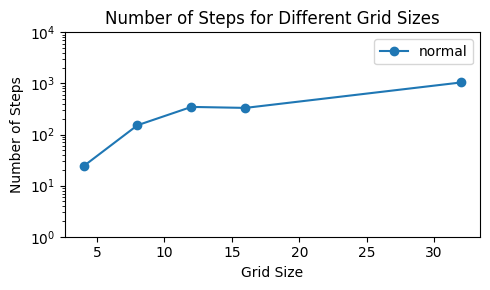

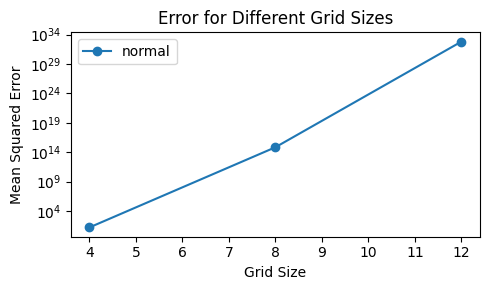

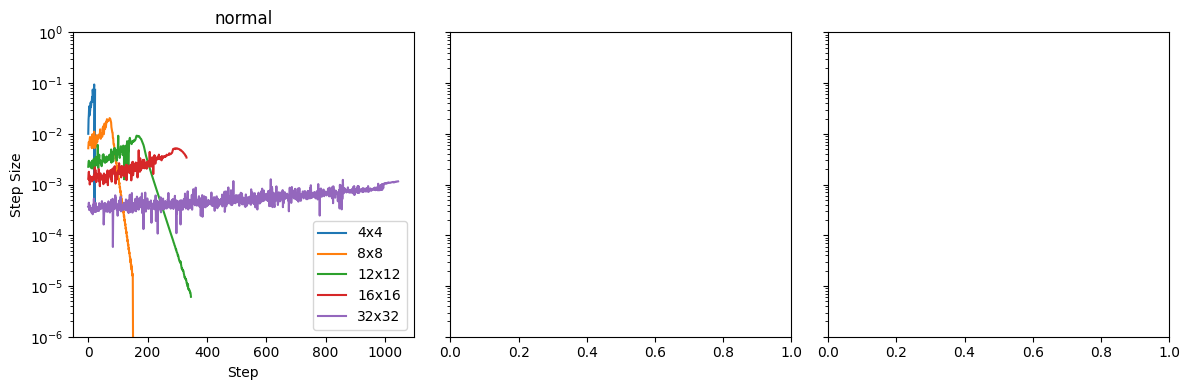

In [40]:
plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(grid_sizes, n_steps[sampling_type[0]], 'o-', label=sampling_type[0])
plt.title('Number of Steps for Different Grid Sizes')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('Grid Size')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_grid_size.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(grid_sizes, n_steps_error[sampling_type[0]], 'o-', label=sampling_type[0])
plt.title('Error for Different Grid Sizes')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('Grid Size')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.savefig(f'plots/{score_model.name}/error_vs_grid_size.png')
plt.show()

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4), tight_layout=True)
for a, sampling_type in zip(ax, sampling_types):
    a.set_title(sampling_type[0])
    for i, n in zip(grid_sizes, n_steps_per_grid[sampling_type[0]]):
        a.plot(n, label=f'{i}x{i}')
    a.set_xlabel('Step')
    a.set_ylabel('Step Size')
    a.set_yscale('log')
    a.legend(loc='lower right')
    a.set_ylim(1e-6, 1)
plt.savefig(f'plots/{score_model.name}/n_steps_per_grid.png')
plt.show()